# Análise Exploratória dos dados de COVID

Rafael Gurgel

## Importa as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from fbprophet import Prophet

from pandas.core.frame import DataFrame
from typing import Optional

## Carrega a base de dados

In [2]:
datafile = Path('input/covid_19_data.csv')
df = pd.read_csv(datafile, parse_dates=['ObservationDate', 'Last Update'])

**Exibe a base carregada**

In [3]:
df.head(5)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## Preparação dos dados

**Exibe os tipos de variáveis carregadas**

In [4]:
# Exibe o tipo das variáveis carregadas no dataframe
print('\033[1m',
      re.sub('Variável', 'Variável\033[0m',
             df.dtypes
               .rename('     Tipo de Variável')
               .to_frame()
               .to_string()))

                      Tipo de Variável
SNo                             int64
ObservationDate        datetime64[ns]
Province/State                 object
Country/Region                 object
Last Update            datetime64[ns]
Confirmed                     float64
Deaths                        float64
Recovered                     float64


**Ajusta o nome das colulas**

In [5]:
def corrige_nome_colunas(col_name: str) -> str:
    '''Ajusta nome das colunas para ficar mais clean'''
    return re.sub(r"[/| ]", "", col_name).lower()

# Corrige o nome das colunas
df.columns = [corrige_nome_colunas(col) for col in df.columns]

# Verifica se o nome das colunas foi alterado
df.head(5)

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## Visualização das Informações

**Seleciona os casos do Brasil**

In [6]:
brasil = df.query('(countryregion == "Brazil") & (confirmed > 0)')

In [7]:
px.line(brasil, 'observationdate', 'confirmed',
        labels={'observationdate': 'Data',
                'confirmed': 'Número de casos confirmados'},
        title='Casos confirmados no Brasil',
        template='plotly_white')

**Visualizando o gráfico de novos casos registrados**

Para a visualização do número de novos casos registrados, é necessário calcular a diferença de casos entre o atual registro e o registro anterior.

O código desta parte será ligeiramente diferente do proposto, com o objetivo de evitar a alteração de valores utilizando o comando `.iloc`, que possui uma série de desvantagens.

Além disso, como forma de garantir a consistência dos resultados, os valores foram previamente ordenados por data de observação.

In [8]:
brasil = brasil \
    .sort_values('observationdate') \
    .assign(novoscasos=lambda x: x.confirmed - x.confirmed.shift(1, fill_value=0))

In [9]:
# Plot novos casos 
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
        labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'},
        template='plotly_white')

**Visualizando o número de mortes registradas**

In [10]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers',
               line=dict(color='red'))
)
# Edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                  xaxis_title='Data',
                  yaxis_title='Número de mortes',
                  template='plotly_white')
fig.show()

### Cálculo de tendências

*Nota: Durante a descrição do projeto foi solicitado o cálculo de uma chamada "taxa de crescimento". Isso, na prática, pode ser interpretado como uma média geométrica do crescimento diário ao longo do período analisado considerando a existência de uma relação exponencial constante (composta). <br>
É importante ressaltar que ao avaliar o crescimento diário na segunda parte também utilizou-se do termo "taxa de crescimento" na descrição do projeto, entretanto, foi analisada uma "variação relativa".
<br>
Apesar de serem parecidos, há uma sutil diferença que impacta na interpretação dos resultados. Para evitar confusões, os nome das funções serão alteradas para se adequarem às definições técnicas dos termos.*

**Taxa de crescimento**

In [11]:
def taxa_crescimento(data: DataFrame,
                            variable: str,
                            data_inicio: Optional[str] = None,
                            data_fim: Optional[str] = None,
                            verbose: bool = True) -> float:
    '''Calcula a taxa de crescimento diária de uma variável para um determinado intervalo de tempo'''

    # Convertendo data_inicio e data_fim para datetime
    data_inicio = pd.to_datetime(
        data_inicio, dayfirst=True) if data_inicio is not None else data['observationdate'].min()
    data_fim = pd.to_datetime(
        data_fim, dayfirst=True) if data_fim is not None else data['observationdate'].max()

    inicio = data.query(
        'observationdate >= @data_inicio')[[variable,  'observationdate']].sort_values('observationdate').iloc[0]
    fim = data.query(
        'observationdate <= @data_fim')[[variable,  'observationdate']].sort_values('observationdate').iloc[-1]

    data_inicio = inicio['observationdate']
    data_fim = fim['observationdate']

    inicio = inicio[variable]
    fim = fim[variable]
    dt = (data_fim - data_inicio).days

    taxas = (fim - inicio)**(1/dt) - 1

    if verbose:
        print(
            f'Taxa de crescimento entre {data_inicio:%d/%m/%Y} e {data_fim:%d/%m/%Y}: \033[1;31m{taxas:.2%}\033[0m')
    return taxas


In [12]:
taxa_crescimento(brasil, 'confirmed');
# Teste de calculo apenas com registros existentes
taxa_crescimento(brasil,'confirmed', data_inicio='01/01/2020', data_fim='01/01/21');

Taxa de crescimento entre 26/02/2020 e 19/05/2020: 16.27%
Taxa de crescimento entre 26/02/2020 e 19/05/2020: 16.27%


Analisando a taxa de crescimento a cada mês é possível perceber uma tendência exponencial

In [13]:
taxa_crescimento(brasil,'confirmed', data_inicio='01/02/2020', data_fim='01/03/20');
taxa_crescimento(brasil,'confirmed', data_inicio='01/03/2020', data_fim='01/04/20');
taxa_crescimento(brasil,'confirmed', data_inicio='01/04/2020', data_fim='01/05/20');
taxa_crescimento(brasil,'confirmed', data_inicio='01/05/2020', data_fim='01/06/20');

Taxa de crescimento entre 26/02/2020 e 01/03/2020: 0.00%
Taxa de crescimento entre 01/03/2020 e 01/04/2020: 32.95%
Taxa de crescimento entre 01/04/2020 e 01/05/2020: 46.01%
Taxa de crescimento entre 01/05/2020 e 19/05/2020: 95.85%


**Variação relativa entre os registros**

In [14]:
def variacao_relativa(data: DataFrame, variable: str, data_inicio: Optional[str]=None) -> np.array:
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)

variacao_registros = variacao_relativa(brasil, 'confirmed')
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()

In [15]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
               y=variacao_registros,
               mode='lines+markers')
)
# Edita o layout
fig.update_layout(title='Variação relativa das atualizações do número de casos confirmados no Brasil',
                  xaxis_title='Data',
                  yaxis_title='Variação relativa',
                  template='plotly_white',
                  yaxis_tickformat = ',.1%')
fig.show()

## Predições

**Decompondo a série de novos casos confirmados**

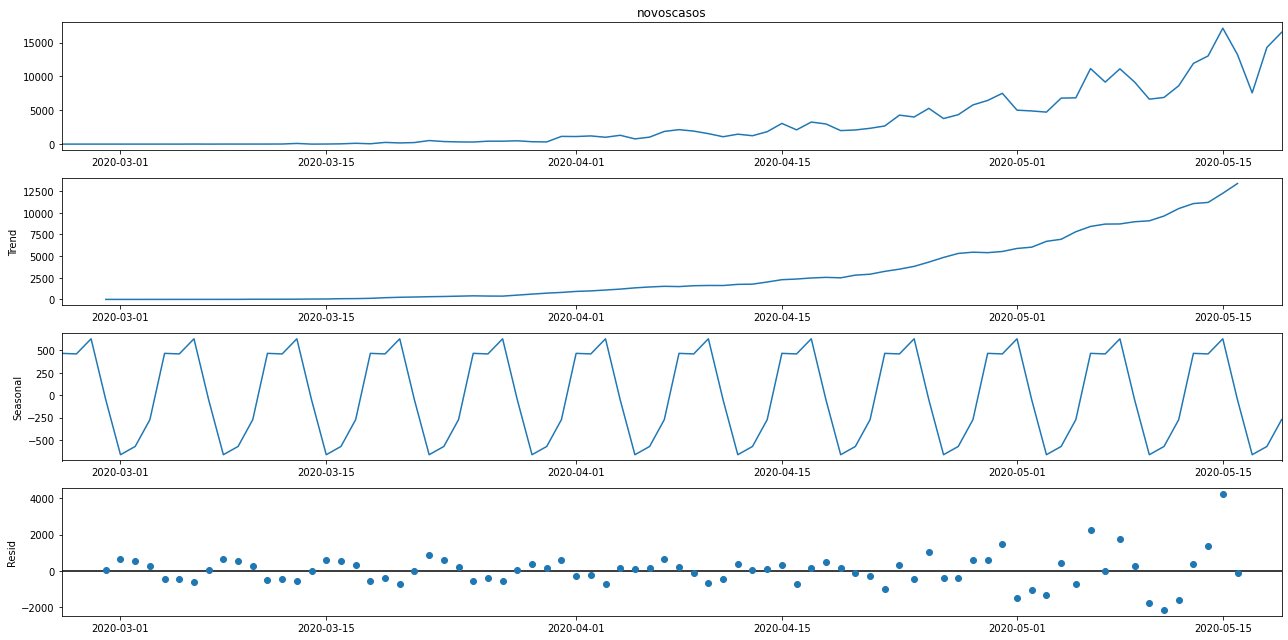

In [16]:
# Cria uma serie no padas usando a data como índice
novoscasos = brasil.set_index('observationdate')['novoscasos']

result_novoscasos = seasonal_decompose(novoscasos)
fig = result_novoscasos.plot()
fig.set_size_inches((18, 9))
fig.tight_layout()
plt.show()

**Decompondo a série de casos confirmados**

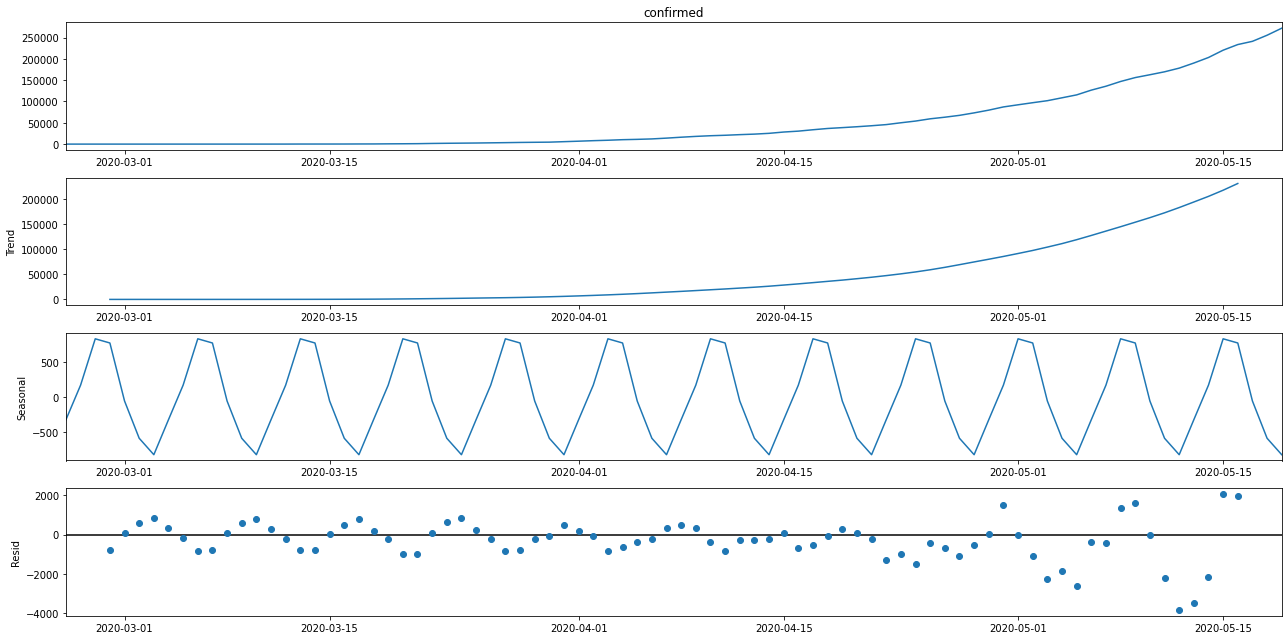

In [17]:
# Cria uma serie no padas usando a data como índice
confirmados = brasil.set_index('observationdate')['confirmed']

result_confirmados = seasonal_decompose(confirmados)
fig = result_confirmados.plot()
fig.set_size_inches((18, 9))
fig.tight_layout()
plt.show()

### Prevendo o número de casos confirmados com modelo ARIMA

In [18]:
modelo = auto_arima(confirmados)

pred = modelo.predict(15)
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pred.index, y=pred.values, name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data',
                 template='plotly_white')
fig.show()

### Modelo de crescimento

Nessa parte será utilizado um modelo de crescimento considerando a limitação populacional para não crescer indefinitivamente.

In [29]:
# preparando os dados
train = confirmados.reset_index()[:-7]
test = confirmados.reset_index()[-7:]

# renomeia colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

profeta = Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'], yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=True)

pop = 211463256

train['cap'] = pop

# Treina o modelo
profeta.fit(train);

/usr/local/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




Initial log joint probability = -5255.57
Iteration  1. Log joint probability =   -2425.74. Improved by 2829.83.
Iteration  2. Log joint probability =   -1679.92. Improved by 745.817.
Iteration  3. Log joint probability =   -1401.04. Improved by 278.885.
Iteration  4. Log joint probability =   -1217.99. Improved by 183.046.
Iteration  5. Log joint probability =   -898.177. Improved by 319.813.
Iteration  6. Log joint probability =   -809.319. Improved by 88.8575.
Iteration  7. Log joint probability =   -626.655. Improved by 182.664.
Iteration  8. Log joint probability =   -625.789. Improved by 0.866666.
Iteration  9. Log joint probability =   -536.166. Improved by 89.6229.
Iteration 10. Log joint probability =   -520.478. Improved by 15.6882.
Iteration 11. Log joint probability =   -398.982. Improved by 121.496.
Iteration 12. Log joint probability =   -232.546. Improved by 166.437.
Iteration 13. Log joint probability =   -164.756. Improved by 67.7891.
Iteration 14. Log joint probabilit

 Improved by 0.397327.
Iteration 248. Log joint probability =    198.142. Improved by 2.34077.
Iteration 249. Log joint probability =    198.152. Improved by 0.00969246.
Iteration 250. Log joint probability =    199.145. Improved by 0.993608.
Iteration 251. Log joint probability =    199.189. Improved by 0.0435195.
Iteration 252. Log joint probability =    199.881. Improved by 0.692392.
Iteration 253. Log joint probability =    199.895. Improved by 0.0141118.
Iteration 254. Log joint probability =    199.902. Improved by 0.00697541.
Iteration 255. Log joint probability =    200.693. Improved by 0.791176.
Iteration 256. Log joint probability =    200.717. Improved by 0.0234688.
Iteration 257. Log joint probability =    201.978. Improved by 1.26124.
Iteration 258. Log joint probability =    201.989. Improved by 0.0108642.
Iteration 259. Log joint probability =    202.097. Improved by 0.108187.
Iteration 260. Log joint probability =    203.769. Improved by 1.67166.
Iteration 261. Log join

A seguir será realizada uma simulação livre para as estimativas de casos do próximo mês.

É importante salientar que em tal simulação há uma propagação de erros, uma vez que o modelo não foi preparado/otimizado para tal horizonte.

De qualquer forma, é possível observar que há uma predição razoável para a próxima semana (conjunto de dados separados para teste e desconhecidos pelo modelo)

In [55]:
%%capture --no-display
# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=30)
future_dates['cap'] = pop
forecast = profeta.predict(future_dates)

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(
    title='Predições de casos confirmados no Brasil', template='plotly_white')
fig.show()


Em seguida é apresentada uma predição para uma faixa ampla, onde, devido a limitação populacional, a taxa de aumento do número de casos reduz, tendendo a um eventual platô de saturação, se aproximando do tamanho da população.

In [53]:
%%capture --no-display
# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast = profeta.predict(future_dates)

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste', mode='lines'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))

fig.update_layout(
    title='Predições de casos confirmados no Brasil', template='plotly_white')
fig.show()
